In [2]:
###_____________Import petsc libraries___________###
%config InlineBackend.figure_format = 'retina'
import petsc4py
PETSC_ARCH="complex_intel"
#PETSC_ARCH="real_intel"
petsc4py.init(arch=PETSC_ARCH)

from petsc4py import PETSc
import numpy as np
import tempfile
import scipy

def csr_to_petsc(M):
    if not isinstance(M,scipy.sparse.csr_matrix):
        raise ValueError("type(M)=%s has to be scipy.sparse.csr_matrix"%type(M))
    return PETSc.Mat().createAIJ(size=M.shape,csr=(M.indptr, M.indices, M.data))

def save_petsc(filename,M):
    if isinstance(M,scipy.sparse.csr_matrix):
        # convert CSR matrices automatically, since we know how to do that
        M = csr_to_petsc(M)
    elif isinstance(M,np.ndarray) and M.ndim==1:
        M = PETSc.Vec().createWithArray(M)
    v = PETSc.Viewer().createBinary(filename,"w")
    v.view(M)
    v.destroy()

def load_petsc_vecs(filename):
    vv = PETSc.Viewer().createBinary(filename,"r")
    vs = []
    while True:
        try:
            vs.append(PETSc.Vec().load(vv).getArray())
        except:
            break
    return np.array(vs)

def petsc_timeprop(H,psi0,ts,tol=1e-8):
    with tempfile.TemporaryDirectory() as d:
        save_petsc(d + "/A.petsc",-1j*H.data)
        save_petsc(d + "/u0.petsc",psi0.full().squeeze())
        save_petsc(d + "/times.petsc",ts)
        !cd {d} && ~feist/laser/petsc_timeprop/src/odesolve.exe -ts_type rk -ts_rk_type 5f -ts_rtol {tol} -ts_atol {tol} -ts_dt 1. -mat_type mpiaijcusparse -vec_type mpicuda
        states = [Qobj(v,dims=psi0.dims) for v in load_petsc_vecs(d + "/usol.petsc")]
    return states

def gauss_state2D(gridX, gridY, x0,y0,c):
    
    RX = gridX.x
    RY = gridY.x
    
    wtX = gridX.wt
    wtY = gridY.wt
    
    exponentX = -(RX - x0)*(RX - x0)/(2*c*c)
    gaussX = Qobj(exp(exponentX)*sqrt(wtX))

    exponentY = -(RY - y0)*(RY - y0)/(2*c*c)
    gaussY = Qobj(exp(exponentY)*sqrt(wtY))
    
    gaussFunct = tensor(gaussX,gaussY).unit()
    
    return gaussFunct

def gauss_potential2D(gridX, gridY, x0,y0,c):

    RX = gridX.x
    RY = gridY.x
    
    sizeX = len(gridX.x)
    sizeY = len(gridY.x)
  
    potX = zeros((sizeX,sizeX),dtype=complex)
    potY = zeros((sizeY,sizeY),dtype=complex)

    potX[range(sizeX),range(sizeX)]=exp(-(RX - x0)*(RX - x0)/(2*c*c))
    potY[range(sizeY),range(sizeY)]=exp(-(RY - y0)*(RY - y0)/(2*c*c))

    potential = Qobj(tensor(Qobj(potX),Qobj(potY)))
    
    return potential



In [3]:
###_____________ Ground state  Function___________###

# %% Create ground state PES

#parameters GX, GY, Gdiag, PESdata=uracil.s[0]

def groundstate(gridX, gridY,GX, GY, Gdiag, PESdata):

    NRX=len(gridX.x)
    NRY=len(gridY.x)
    # %% Position operators
    
    posX = zeros((NRX,NRX),dtype=complex)
    posY = zeros((NRY,NRY),dtype=complex)

    posX[range(NRX),range(NRX)]=gridX.x
    posY[range(NRY),range(NRY)]=gridY.x

    PosX = Qobj(tensor(Qobj(posX),qeye(NRY)))
    PosY = Qobj(tensor(qeye(NRX),Qobj(posY)))


    # %% Kinetic energy tensor --
    
    dX_loc = Qobj(gridX.dx.toarray()) # x derivative
    DX = tensor(dX_loc,qeye(NRY))

    dX2_loc = Qobj(gridX.dx2.toarray()) # x second derivative
    DX2 = tensor(dX2_loc,qeye(NRY))

    dY_loc = Qobj(gridY.dx.toarray()) # y derivative
    DY = tensor(qeye(NRX),dY_loc)

    dY2_loc = Qobj(gridY.dx2.toarray()) # y second derivative
    DY2 = tensor(qeye(NRX),dY2_loc)

    DXY = tensor(dX_loc,dY_loc)

    Tens = (-1/2)*( GX*DX2 + GY*DY2 + 2*Gdiag*DXY )

    PES0 = qdiags(transpose(PESdata).flatten(),0,dims=[[NRX,NRY],[NRX,NRY]]) # Import PES and reshape
    
    # Ground-state Hamiltonian
    Hgs = Tens + PES0

    vals,vecgs=Hgs.eigenstates(sparse=True,eigvals=1)
    
    return vecgs[0]

In [4]:
#---- Gobbler Function
def craxi(gridX, gridY, x0,x1,y0,y1,cx,cy):
    
    RX = gridX.x
    RY = gridY.x
    
    sizeX = len(gridX.x)
    sizeY = len(gridY.x)
    
    Z = zeros((sizeX,sizeY),dtype=complex)
    x0=x0*angtobohr
    x1=x1*angtobohr
    y0=y0*angtobohr
    y1=y1*angtobohr
    for i in range(sizeX):
        for j in range(sizeY):
            #Z[i,j] = exp(cx*(RX[i] - RX[x0_ind])**2 + cy*(RY[j] - RY[y0_ind])**2 ) - 1  # exp(c*(RX[i]- x0 + RY[j] - y0))
            #Z[i,j] = (cx*(RX[i] - RX[x0_ind])**2 + cy*(RY[j] - RY[y0_ind])**2)  # exp(c*(RX[i]- x0 + RY[j] - y0))
            
            #Z[i,j] = (cx*(RX[i] - RX[x0_ind])**2 + cy*(RY[j] - RY[y0_ind])**2)  # exp(c*(RX[i]- x0 + RY[j] - y0))
            
            if (RX[i] < x0):            
                Z[i,j] += cx*(RX[i]- x0)**2  #(cx*(RX[i] - RX[x0_ind])**2 + cy*(RY[j] - RY[y0_ind])**2)  # exp(c*(RX[i]- x0 + RY[j] - y0))
 
                
            if (RX[i] > x1):            
                Z[i,j] += cx*(RX[i]- x1)**2  #(cx*(RX[i] - RX[x0_ind])**2 + cy*(RY[j] - RY[y0_ind])**2)  # exp(c*(RX[i]- x0 + RY[j] - y0))

            if (RY[j] < y0):            
                Z[i,j] += cy*(RY[j] - y0)**2#(cx*(RX[i] - RX[x0_ind])**2 + cy*(RY[j] - RY[y0_ind])**2)  # exp(c*(RX[i]- x0 + RY[j] - y0))

            if (RY[j] > y1):            
                 Z[i,j] += cy*(RY[j] - y1)**2#(cx*(RX[i] - RX[x0_ind])**2 + cy*(RY[j] - RY[y0_ind])**2)  # exp(c*(RX[i]- x0 + RY[j] - y0))       
    
    return Z.T

def craxi_PES(gridX, gridY,surface, c, scaling, coeff):
    
    cutoff = c*evtoau
    
    sizeX = len(gridX.x)
    sizeY = len(gridY.x)
    
    PES = transpose(surface - surface.min())
    
    Z = zeros((sizeX,sizeY),dtype=complex)
    for i in range(sizeX):
        for j in range(sizeY):
            if PES[i,j]>cutoff:
                #Z[i,j] = exp(scaling*(PES[i,j]-cutoff))
                Z[i,j] = evtoau*coeff*(exp(scaling*(PES[i,j]-cutoff)) - 1)
            #Z[i,j] = exp(cx*(R
    
    return Z.T

In [5]:
###_____________Import  libraries, generic definitions___________###

#import ipyvolume as ipv
from jftools.fedvr import fedvr_grid
from numpy import *
from numpy.linalg import *
from scipy import *
#from scipy.linalg import *
import os
from qutip import *
#from util_2D import *
from matplotlib.pyplot import *
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import time
import sys
from mpl_toolkits.mplot3d import Axes3D

## Constants
angtobohr=1/0.52917721067121
evtoau=1/27.211399
autofs=0.02418884254

# Color scheme
col=["navy","darkorange","purple","steelblue","darkorange"] # Pes 0, Pes 1, Kinetic

#FLAG TO SAVE FIGURES IN $PATH/, if False no save
saveplot = 0
 
#path= "TestFebGridDim"#"Lin_cross_complete" #FOLDER TO SAVE
path= "Best"


if not os.path.exists(path):
    os.mkdir(path)

In [6]:
###_____________Define grid properties___________###

# %% Import external data 
import mol_class
uracil = mol_class.mol(3,"./mat/") #number of states, path to find the matrices

from copy import deepcopy # needed to modify the grid according to boundary conditions

# %% Grid parameters

nfun = 10

#X_array = linspace(-2,4,12)
X_array = linspace(-3.7795,5.66918,12)
bare_gridX = fedvr_grid(nfun, X_array)

#Y_array = linspace(-2,3,11)
Y_array = linspace(-2.1101,2.8550,11)
bare_gridY = fedvr_grid(nfun, Y_array)

# Enforce Dirichelet boundary conditions (functions must vanish at the borders)
gridX = deepcopy(bare_gridX)
gridY = deepcopy(bare_gridY)
gridX.x = gridX.x[1:-1]
gridY.x = gridY.x[1:-1]
gridX.wt = gridX.wt[1:-1]
gridY.wt = gridY.wt[1:-1]
gridX.dx = bare_gridX.dx[1:-1,1:-1]
gridY.dx = bare_gridY.dx[1:-1,1:-1]
gridX.dx2 = bare_gridX.dx2[1:-1,1:-1]
gridY.dx2 = bare_gridY.dx2[1:-1,1:-1]

NRX=len(gridX.x)
NRY=len(gridY.x)
#we don't need angstrom and conversions anymore, since Regina's files are already in bohr. 

# Import Molecular model
uracil.gen_coords(gridX.x,gridY.x)

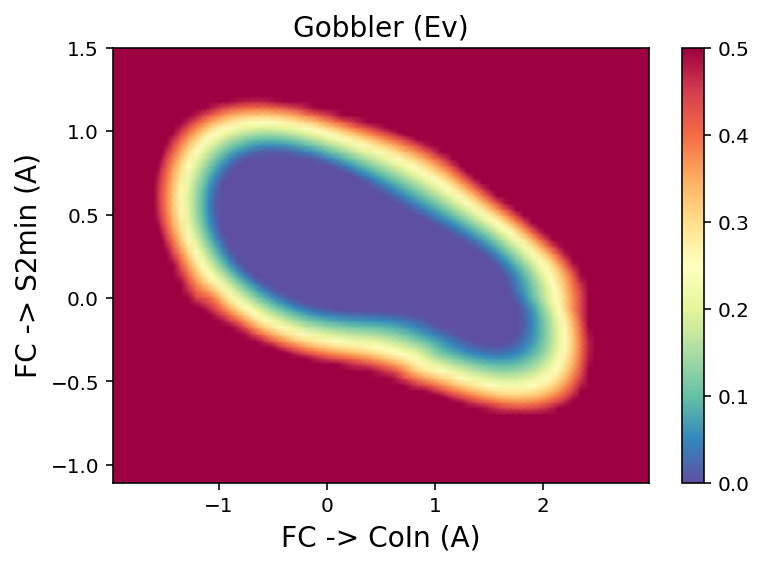

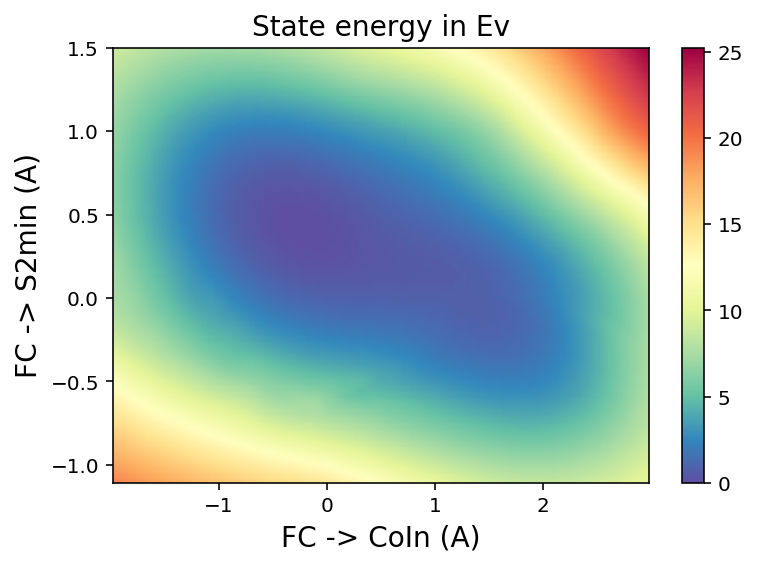

In [7]:
#---- Gobbler Evaluation
Delta = uracil.s[2] - uracil.s[1]
amin(Delta)
pos_CI = where(Delta == amin(Delta))
y_CI = pos_CI[0].item()
x_CI = pos_CI[1].item()

fig=figure()
#fig.set_size_inches(20,8)

#gobbler_potential = craxi(gridX,gridY,x_CI,y_CI,0.3,1)


#gobbler_potential = evtoau*craxi(gridX,gridY,-0.9,1.8,-0.3,0.8,1,2)


#Vecchi valori gobbler craxi_PES(gridX,gridY,uracil.s[1],1.0,0.05,20)

gobbler_potential = craxi_PES(gridX,gridY,uracil.s[1],1.2,0.05,100) #(..cutoff, scaling, coeff)
    
Z = gobbler_potential/evtoau

pcolormesh(gridX.x/angtobohr,gridY.x/angtobohr,Z.real,shading='gouraud',cmap = 'Spectral_r',vmin = 0, vmax = 0.5)
#axis('scaled')
colorbar(shrink = 1)
textbx = "Gobbler (Ev)"
title(textbx, fontsize=14)
xlabel("FC -> CoIn (A)",size=14)
ylabel("FC -> S2min (A)",size=14)


Z = uracil.s[1]

fig=figure()
Z = uracil.s[1]/evtoau
Z = Z - Z.min()

pcolormesh(gridX.x/angtobohr,gridY.x/angtobohr,Z,shading='gouraud',cmap = 'Spectral_r')#,vmin = 0, vmax = 3)
colorbar(shrink = 1)
textbx = "State energy in Ev"
title(textbx, fontsize=14)
xlabel("FC -> CoIn (A)",size=14)
ylabel("FC -> S2min (A)",size=14);



-0.4133463276354692

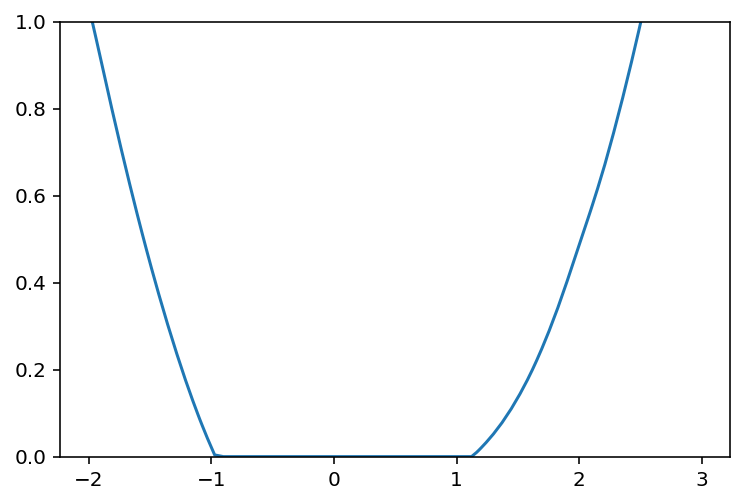

In [7]:
plot(gridX.x/angtobohr, (gobbler_potential[50,:]/evtoau).real);
ylim(0,1)
gridY.x[30]

89
(89, 98)


Text(0, 0.5, 'FC -> S2min (A)')

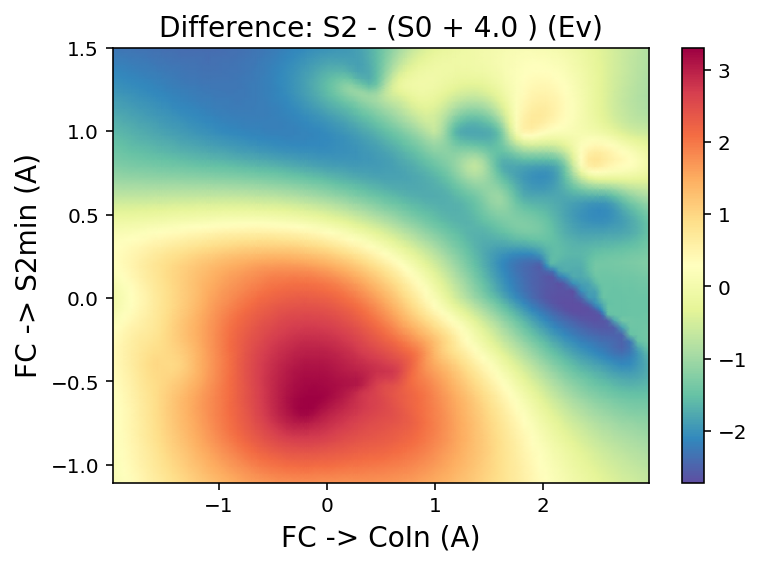

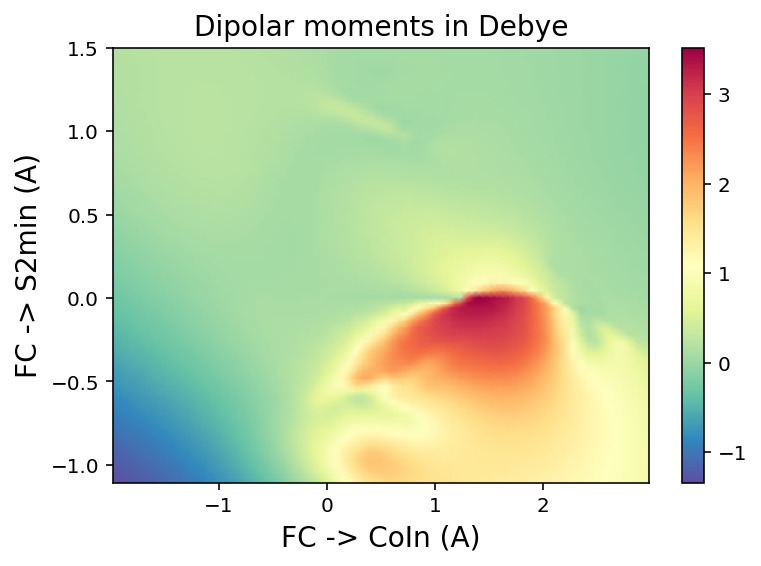

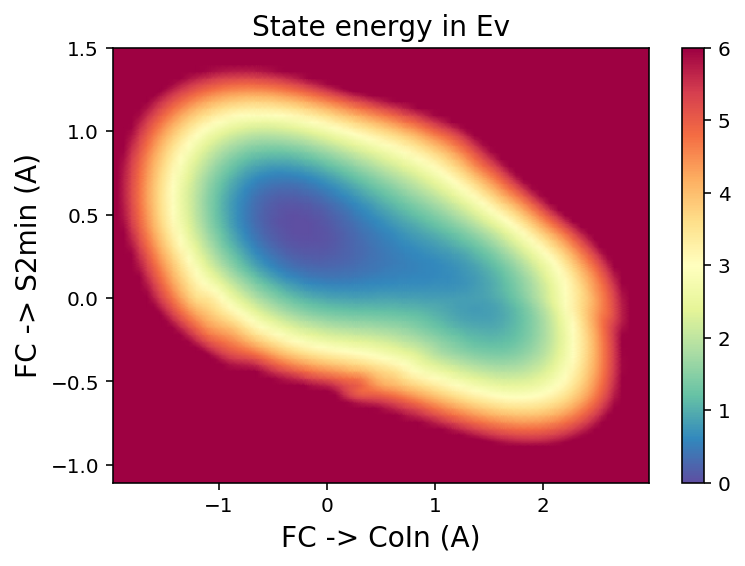

In [12]:
###_____________ Visualize PES properties ___________###
#---- Difference
fig=figure()
#fig.set_size_inches(20,8)
omega_cav = 4*evtoau #0.64*evtoau # 0.64 is the difference between S2
Z2 = uracil.s[2]/evtoau
Z1 = (uracil.s[0]+ omega_cav)/evtoau  

pcolormesh(gridX.x/angtobohr,gridY.x/angtobohr,Z2-Z1,shading='gouraud',cmap = 'Spectral_r')#,vmin = -0.5, vmax = 0.5)
#axis('scaled')
colorbar(shrink = 1)
textbx = "Difference: S2 - (S0 + "+ str(omega_cav/evtoau) + " ) (Ev)"
#fig.text(0.5, 0.8, textbx,  fontsize=14,verticalalignment='top', horizontalalignment='center')
title(textbx, fontsize=14)
xlabel("FC -> CoIn (A)",size=14)
ylabel("FC -> S2min (A)",size=14)
#ylim(-0.4,0.9)
#xlim(-1,2);

#---- Dipolar moments
fig=figure()
Z = uracil.tdm[0][0]*2.54 # Debye

pcolormesh(gridX.x/angtobohr,gridY.x/angtobohr,Z,shading='gouraud',cmap = 'Spectral_r')#,vmin = 0, vmax = 4)
#axis('scaled')
colorbar(shrink = 1)
textbx = "Dipolar moments in Debye"
title(textbx, fontsize=14)
xlabel("FC -> CoIn (A)",size=14)
ylabel("FC -> S2min (A)",size=14)
#ylim(-0.4,0.9);

#---- PES
fig=figure()
Z = uracil.s[1]/evtoau
Z = Z - Z.min()
print(len(gridY.x))
print(np.shape(Z))
pcolormesh(gridX.x/angtobohr,gridY.x/angtobohr,Z,shading='gouraud',vmin = 0, vmax = 6,cmap = 'Spectral_r')
colorbar(shrink = 1)
textbx = "State energy in Ev"
title(textbx, fontsize=14)
xlabel("FC -> CoIn (A)",size=14)
ylabel("FC -> S2min (A)",size=14)
#ylim(-0.4,0.9)
#xlim(-1,2);

In [9]:
###_____________ Generate Groundstate ___________###
GX = 1.671e-4
GY = 1.388e-4
Gdiag = -0.704e-4

ground_wp = groundstate(gridX,gridY, GX, GY, Gdiag, uracil.s[0]) # Diagonalize ground-state Hamiltonian
wavepacket_gs = (abs(ground_wp.full().reshape(NRX,NRY))**2)/ (gridX.wt[:,None] * gridY.wt[None,:])
#fig = figure(figsize=(10,10))

Z = wavepacket_gs/wavepacket_gs.max()
#pcolormesh(gridX.x/angtobohr,gridY.x/angtobohr,Z.T,shading='gouraud',vmin=0, vmax = 1, cmap='Spectral_r')
#axis('scaled')
#colorbar(shrink = 1)
#textbx = "Ground state wavefunction"
#title(textbx, fontsize=14)
#xlabel("FC -> CoIn (A)",size=14)
#ylabel("FC -> S2min (A)",size=14);
#xlim(-1,2)
#ylim(-0.4,0.9);

In [10]:
###_____________ Hilbert-space definition ___________###

Nstates = 3 # Number of states

# %% Position operators

posX = zeros((NRX,NRX),dtype=complex)
posY = zeros((NRY,NRY),dtype=complex)

posX[range(NRX),range(NRX)]=gridX.x
posY[range(NRY),range(NRY)]=gridY.x

PosX = Qobj(tensor(Qobj(posX), qeye(NRY), qeye(Nstates)))
PosY = Qobj(tensor(qeye(NRX), Qobj(posY), qeye(Nstates)))
# %% Kinetic energy -- 

#M = 1000
#Tx = -1/(2*M)*gridX.dx2 # Kinetic energy
#Ty = -1/(2*M)*gridY.dx2 # Kinetic energy
#Tx = Qobj(Tx.toarray())
#Ty = Qobj(Ty.toarray())
#KinX = Qobj(tensor(Tx, qeye(NRY)))   # Global operator for kinetic energy along x
#KinY = Qobj(tensor(qeye(NRX),Ty))    # Global operator for kinetic energy along y


# %% Kinetic energy tensor --

dX_loc = Qobj(gridX.dx.toarray()) # x derivative
DX = tensor(dX_loc,qeye(NRY), qeye(Nstates))

dX2_loc = Qobj(gridX.dx2.toarray()) # x second derivative
DX2 = tensor(dX2_loc,qeye(NRY), qeye(Nstates))

dY_loc = Qobj(gridY.dx.toarray()) # y derivative
DY = tensor(qeye(NRX),dY_loc, qeye(Nstates))

dY2_loc = Qobj(gridY.dx2.toarray()) # y second derivative
DY2 = tensor(qeye(NRX),dY2_loc, qeye(Nstates))

DXY = tensor(dX_loc,dY_loc, qeye(Nstates))

Tens = (-1/2)*( GX*DX2 + GY*DY2 + 2*Gdiag*DXY )

P = -1j*(DX + DY)
Px = -1j*DX
Py = -1j*DY

In [11]:
###_____________ Strong-coupling Parameters definition ___________###


filename = "StrongC_gam" # run_name

# \sqrt{ω/V_eff}
e1ph = 0.001# 0.001
omega_cav = 3*evtoau#0.64*evtoau

gamma = 0.05*evtoau # 0.05

# Check the value of the Rabi splitting
maxcoupling = e1ph*((uracil.tdm[1][0]).max())/(evtoau) # Effective maximum rabi splitting in Ev
print("E1ph corresponds to a maximum coupling of: "+ str(maxcoupling)+" (Ev)")
print("Cavity lifetime:"+str(gamma)+"fs")

E1ph corresponds to a maximum coupling of: 0.045377879530636024 (Ev)
Cavity lifetime:0.0018374652475604066fs


In [12]:
###_____________ Dynamical evolution ___________###

# %% Define projectors
P_A = zeros((Nstates,Nstates),dtype=complex)
P_B = zeros((Nstates,Nstates),dtype=complex)
P_C = zeros((Nstates,Nstates),dtype=complex)
P_A[0,0] = 1
P_B[1,1] = 1
P_C[2,2] = 1
P_A = Qobj(P_A) # Local projectors on electronic state, in reduced Hilbert space
P_B = Qobj(P_B)
P_C = Qobj(P_C)

Projector_A = tensor(qeye(NRX),qeye(NRY),P_A)
Projector_B = tensor(qeye(NRX),qeye(NRY),P_B)
Projector_C = tensor(qeye(NRX),qeye(NRY),P_C)

# %% Generate molecular model for the evolution


#- 1j*gobbler_potential

# S2-0 PES
PES_A = qdiags(transpose(uracil.s[2]).flatten(),0,dims=[[NRX,NRY],[NRX,NRY]])
PES_A = tensor(PES_A,P_A)

# S1-1 PES
PES_B = qdiags(transpose(uracil.s[0] + omega_cav - 1j*gamma).flatten(),0,dims=[[NRX,NRY],[NRX,NRY]]) # Import PES and reshape
PES_B = tensor(PES_B,P_B) # Tensor product within two-PES Hilbert space

# S1-0 PES
PES_C = qdiags(transpose(uracil.s[1] - 1j*gobbler_potential).flatten(),0,dims=[[NRX,NRY],[NRX,NRY]]) # Import PES and reshape
PES_C = tensor(PES_C,P_C) # Tensor product within two-PES Hilbert space


# Dipolar coupling
Dipolar = qdiags(transpose(e1ph*uracil.tdm[0][1]).flatten(),0,dims=[[NRX,NRY],[NRX,NRY]]) # Import dipoles and reshape
Dipolar = tensor(Dipolar,Qobj(array([[0,1,0],[1,0,0],[0,0,0]])))


# Nonadiabatic couplings

Nonadiabaticx = qdiags(transpose(uracil.nacx[1][0]).flatten(),0,dims=[[NRX,NRY],[NRX,NRY]]) # Import dipoles and reshape
Nonadiabaticx = tensor(Nonadiabaticx,Qobj(array([[0,0,1],[0,0,0],[1,0,0]])))

Nonadiabaticy = qdiags(transpose(uracil.nacy[1][0]).flatten(),0,dims=[[NRX,NRY],[NRX,NRY]]) # Import dipoles and reshape
Nonadiabaticy = tensor(Nonadiabaticy,Qobj(array([[0,0,1],[0,0,0],[1,0,0]])))


Hnonad = Px*Nonadiabaticx + Nonadiabaticx*Px + Py*Nonadiabaticy + Nonadiabaticy*Py

# Evolution Hamiltonian
Hevo = Tens + PES_A + PES_B + PES_C  + Hnonad + Dipolar



In [13]:
#gino =  Hevo 
#(gino.trans().conj() - gino).full().max()

In [14]:
###_____________ Dynamics ___________###

# %% Initial state definition

# wavepacket
psi0 = ground_wp #  Ground state

# Load to PES
s_A = Qobj(array([1,0,0]))

psi0 = tensor(psi0,s_A)

# Evaluate time evolution

max_t = 300/autofs
ts = linspace(0,max_t,701)
print("Propagate until t= %d au" % max_t) 
states = petsc_timeprop(Hevo,psi0,ts,1e-10)

Propagate until t= 12402 au
 time for initialization:   4.24532245800000     
 time for loading problem etc:   4.99532393200000     
propagated until t =    17.72     in   0.4392     seconds with       43 timesteps
propagated until t =    35.44     in   0.5519     seconds with       86 timesteps
propagated until t =    53.15     in   0.6624     seconds with      129 timesteps
propagated until t =    70.87     in   0.7716     seconds with      172 timesteps
propagated until t =    88.59     in   0.8804     seconds with      215 timesteps
propagated until t =    106.3     in   0.9891     seconds with      258 timesteps
propagated until t =    124.0     in    1.098     seconds with      301 timesteps
propagated until t =    141.7     in    1.208     seconds with      344 timesteps
propagated until t =    159.5     in    1.317     seconds with      387 timesteps
propagated until t =    177.2     in    1.427     seconds with      430 timesteps
propagated until t =    194.9     in    1.537  

propagated until t =    1772.     in    11.39     seconds with     4317 timesteps
propagated until t =    1789.     in    11.50     seconds with     4360 timesteps
propagated until t =    1807.     in    11.61     seconds with     4403 timesteps
propagated until t =    1825.     in    11.72     seconds with     4446 timesteps
propagated until t =    1843.     in    11.83     seconds with     4489 timesteps
propagated until t =    1860.     in    11.94     seconds with     4532 timesteps
propagated until t =    1878.     in    12.05     seconds with     4575 timesteps
propagated until t =    1896.     in    12.16     seconds with     4618 timesteps
propagated until t =    1914.     in    12.27     seconds with     4661 timesteps
propagated until t =    1931.     in    12.38     seconds with     4704 timesteps
propagated until t =    1949.     in    12.49     seconds with     4747 timesteps
propagated until t =    1967.     in    12.60     seconds with     4790 timesteps
propagated until

propagated until t =    3544.     in    22.39     seconds with     8617 timesteps
propagated until t =    3561.     in    22.50     seconds with     8660 timesteps
propagated until t =    3579.     in    22.61     seconds with     8703 timesteps
propagated until t =    3597.     in    22.72     seconds with     8746 timesteps
propagated until t =    3614.     in    22.83     seconds with     8789 timesteps
propagated until t =    3632.     in    22.94     seconds with     8832 timesteps
propagated until t =    3650.     in    23.05     seconds with     8875 timesteps
propagated until t =    3668.     in    23.16     seconds with     8918 timesteps
propagated until t =    3685.     in    23.28     seconds with     8961 timesteps
propagated until t =    3703.     in    23.39     seconds with     9004 timesteps
propagated until t =    3721.     in    23.50     seconds with     9047 timesteps
propagated until t =    3738.     in    23.61     seconds with     9090 timesteps
propagated until

propagated until t =    5315.     in    33.37     seconds with    12890 timesteps
propagated until t =    5333.     in    33.47     seconds with    12932 timesteps
propagated until t =    5351.     in    33.58     seconds with    12974 timesteps
propagated until t =    5368.     in    33.69     seconds with    13016 timesteps
propagated until t =    5386.     in    33.80     seconds with    13058 timesteps
propagated until t =    5404.     in    33.91     seconds with    13100 timesteps
propagated until t =    5422.     in    34.02     seconds with    13142 timesteps
propagated until t =    5439.     in    34.12     seconds with    13184 timesteps
propagated until t =    5457.     in    34.23     seconds with    13226 timesteps
propagated until t =    5475.     in    34.34     seconds with    13268 timesteps
propagated until t =    5492.     in    34.45     seconds with    13310 timesteps
propagated until t =    5510.     in    34.56     seconds with    13352 timesteps
propagated until

propagated until t =    7087.     in    44.07     seconds with    17053 timesteps
propagated until t =    7105.     in    44.18     seconds with    17094 timesteps
propagated until t =    7123.     in    44.28     seconds with    17135 timesteps
propagated until t =    7140.     in    44.39     seconds with    17176 timesteps
propagated until t =    7158.     in    44.49     seconds with    17217 timesteps
propagated until t =    7176.     in    44.60     seconds with    17258 timesteps
propagated until t =    7193.     in    44.70     seconds with    17299 timesteps
propagated until t =    7211.     in    44.81     seconds with    17340 timesteps
propagated until t =    7229.     in    44.91     seconds with    17381 timesteps
propagated until t =    7247.     in    45.02     seconds with    17422 timesteps
propagated until t =    7264.     in    45.12     seconds with    17463 timesteps
propagated until t =    7282.     in    45.23     seconds with    17504 timesteps
propagated until

propagated until t =    8859.     in    54.45     seconds with    21095 timesteps
propagated until t =    8877.     in    54.55     seconds with    21134 timesteps
propagated until t =    8894.     in    54.65     seconds with    21173 timesteps
propagated until t =    8912.     in    54.75     seconds with    21212 timesteps
propagated until t =    8930.     in    54.85     seconds with    21251 timesteps
propagated until t =    8947.     in    54.95     seconds with    21290 timesteps
propagated until t =    8965.     in    55.05     seconds with    21329 timesteps
propagated until t =    8983.     in    55.15     seconds with    21368 timesteps
propagated until t =    9001.     in    55.25     seconds with    21407 timesteps
propagated until t =    9018.     in    55.35     seconds with    21446 timesteps
propagated until t =    9036.     in    55.45     seconds with    21485 timesteps
propagated until t =    9054.     in    55.55     seconds with    21524 timesteps
propagated until

propagated until t =   0.1063E+05 in    64.40     seconds with    24967 timesteps
propagated until t =   0.1065E+05 in    64.50     seconds with    25005 timesteps
propagated until t =   0.1067E+05 in    64.60     seconds with    25043 timesteps
propagated until t =   0.1068E+05 in    64.70     seconds with    25081 timesteps
propagated until t =   0.1070E+05 in    64.79     seconds with    25119 timesteps
propagated until t =   0.1072E+05 in    64.89     seconds with    25157 timesteps
propagated until t =   0.1074E+05 in    64.99     seconds with    25195 timesteps
propagated until t =   0.1075E+05 in    65.09     seconds with    25233 timesteps
propagated until t =   0.1077E+05 in    65.18     seconds with    25271 timesteps
propagated until t =   0.1079E+05 in    65.28     seconds with    25309 timesteps
propagated until t =   0.1081E+05 in    65.38     seconds with    25347 timesteps
propagated until t =   0.1083E+05 in    65.48     seconds with    25385 timesteps
propagated until

propagated until t =   0.1240E+05 in    74.11     seconds with    28713 timesteps
 time for time propagation:   74.1051667140000     
 time for total program run:   79.1005935840000     


150.85714285714286


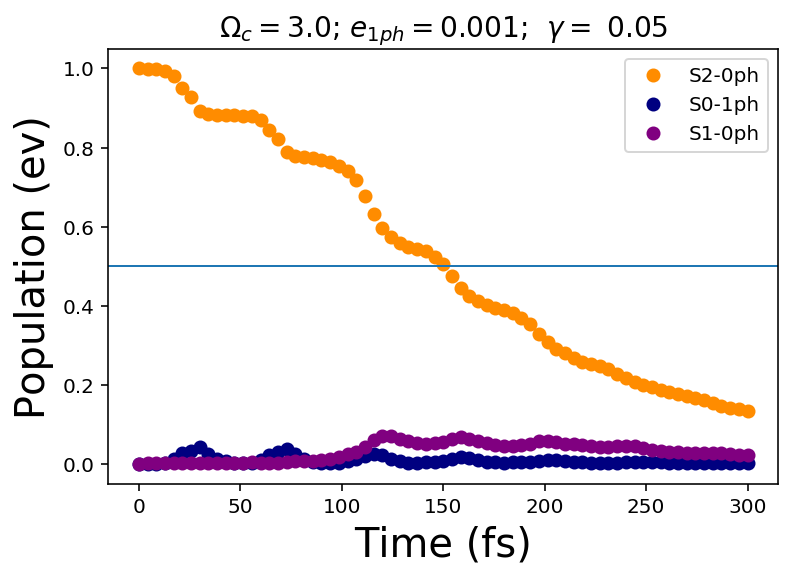

In [15]:
###_____________ Plot Population ___________###

# %% Evaluate observables

PosX_A = PosX*Projector_A
PosY_A = PosY*Projector_A

PosX_B = PosX*Projector_B
PosY_B = PosY*Projector_B


Exp_Pop_A = expect(Projector_A,states)
Exp_Pop_B = expect(Projector_B,states)
Exp_Pop_C = expect(Projector_C,states)

Exp_PosX_A = expect(PosX_A,states)
Exp_PosY_A = expect(PosY_A,states)

Exp_PosX_B = expect(PosX_B,states)
Exp_PosY_B = expect(PosY_B,states)

# %% Plot population

fig=figure()
#fig.set_size_inches(10,10)
 
plot(ts*autofs,Exp_Pop_A,'r--',marker="o",markersize=6,markevery=10,color=col[1],lw=0,label="S2-0ph")
plot(ts*autofs,Exp_Pop_B,'r--',marker="o",markersize=6,markevery=10,color=col[0],lw=0,label="S0-1ph")
plot(ts*autofs,Exp_Pop_C,'r--',marker="o",markersize=6,markevery=10,color=col[2],lw=0,label="S1-0ph")
legend()
xlabel("Time (fs)",size=20)
ylabel("Population (ev)",size=20)
#ylim(0.6,1.1)
#axhline(y=0, xmin=0, xmax=1, **kwargs)[source]
axhline(y=0.5,lw=1)
textbx = r"$\Omega_{c} = $" + str(round(omega_cav/evtoau,4)) + "; " + "$e_{1ph} = $" + str(round(e1ph,4)) + "; " + " $\gamma =$ " + str(round(gamma/evtoau,4))
title(textbx, fontsize=14)
if saveplot==1:
    savefig(path+"/"+filename+"Population"+".pdf",dpi=300)
    
# %%  Evaluate population-inversion time 
ind = abs(Exp_Pop_A - 0.5).argmin()
print(ts[ind]*autofs)


In [16]:
###_____________ Save data ___________###

par = zeros(len(ts))-1
par[0] = omega_cav
par[1] = e1ph
par[2] = gamma
data = column_stack((ts,Exp_Pop_A,Exp_Pop_B,Exp_Pop_C,par))
savetxt(path+"/"+filename+".dat", data)



-0.1193927233988619


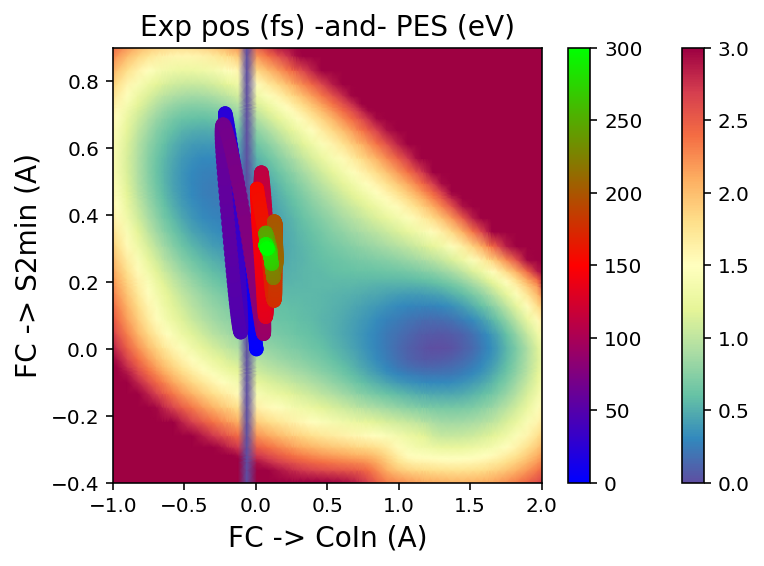

In [17]:
###_____________ Plot center of mass ___________###

fig=figure()
#fig.set_size_inches(20,8)
# %% Select background PES

#___ PES 2
Z = uracil.s[2]/evtoau
Z = Z - min(Z.reshape(NRX*NRY))

# Apply vertical line
#value_CoIn = average(Exp_PosX_A/Exp_Pop_A)/angtobohr # Evaluate average position in CoIn coordinate
value_CoIn = -0.11636310052010965
ind_CoIn = abs(gridX.x - value_CoIn).argmin() # find index
print(gridX.x[ind_CoIn])

Z[:,ind_CoIn]=  0

pcolormesh(gridX.x/angtobohr,gridY.x/angtobohr,Z,shading='gouraud',vmin = 0, vmax = 3,cmap = 'Spectral_r')
colorbar(shrink = 1)
colors = ts*autofs
scatter((Exp_PosX_A/Exp_Pop_A)/angtobohr,(Exp_PosY_A/Exp_Pop_A)/angtobohr,c=colors, cmap='brg')#color=customap)
colorbar(shrink = 1)
#plot(Exp_PosX/angtobohr,Exp_PosY/angtobohr,'r--',marker="o",markersize=6,markevery=10,color=col[0],lw=0,label="Exp_PosX")
textbx = "Exp pos (fs) -and- PES (eV)"
#fig.text(0.5, 0.8, textbx,  fontsize=14,verticalalignment='top', horizontalalignment='center')
title(textbx, fontsize=14)
xlabel("FC -> CoIn (A)",size=14)
ylabel("FC -> S2min (A)",size=14)

ylim(-0.4,0.9)
xlim(-1,2)

if saveplot==1:
    savefig(path+"/"+filename+"CoM"+".pdf",dpi=300)


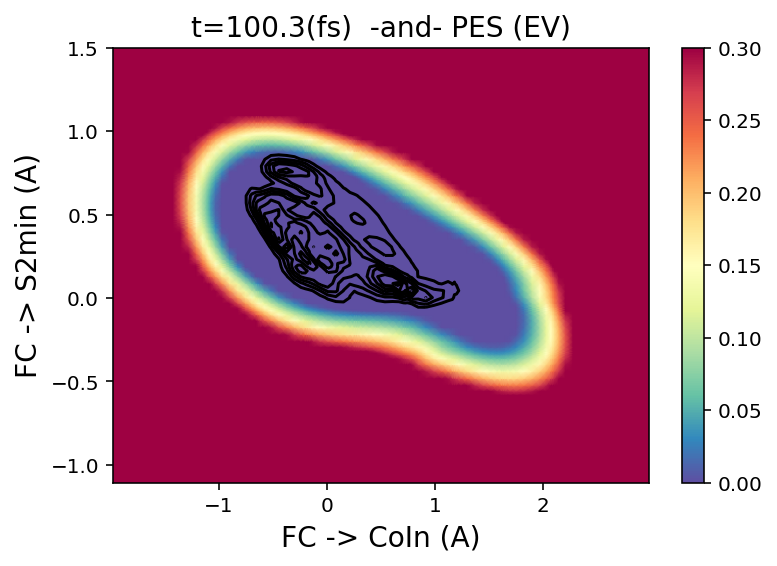

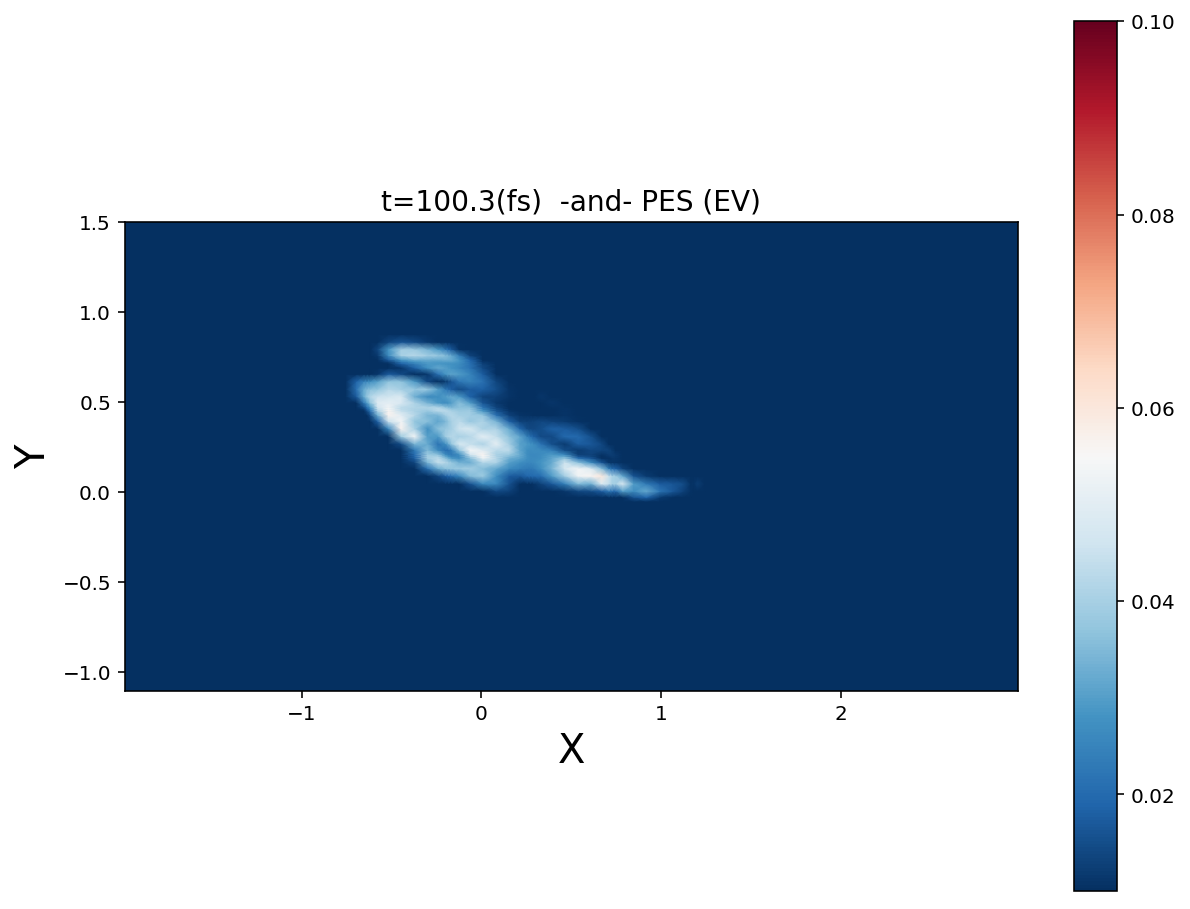

In [18]:
###_____________ Plot contours ___________###

# Extract wavefunction distribution at a given time

state = 0 # 0 selects S2-0 ; 1 selects s1-1 ; 2 selects s20
wavepacket_evo = array([(abs(s.full().reshape(NRX,NRY,Nstates))**2)[:,:,state] for s in states]) / (gridX.wt[None,:,None] * gridY.wt[None,None,:])

# %% Select time

time = 100# (fs)
time_ind = round((time/autofs)*len(ts)/max_t)

###_____________ Plot contours ___________###

fig=figure()

Z = gobbler_potential/evtoau #uracil.s[1]/evtoau
#Z = uracil.s[1]/evtoau
Z = Z - Z.min()

pcolormesh(gridX.x/angtobohr,gridY.x/angtobohr,Z.real,shading='gouraud',cmap = 'Spectral_r',vmin=0,vmax=0.3)
colorbar(shrink = 1)

z_states = (wavepacket_evo[time_ind,:,:].T)/wavepacket_evo.max()
contour(gridX.x/angtobohr,gridY.x/angtobohr,z_states, colors='k')
#axis('scaled')

timestring = "{:.1f}".format(ts[time_ind]*autofs)
textbx = "t="+timestring + "(fs)" + "  -and- PES (EV)"
#fig.text(0.5, 0.8, textbx,  fontsize=14,verticalalignment='top', horizontalalignment='center')
title(textbx, fontsize=14)
xlabel("FC -> CoIn (A)",size=14)
ylabel("FC -> S2min (A)",size=14);
#xlim(-1,2)
#ylim(-0.5,0.8)

###_____________ Plot wavepacket ___________###

fig = figure(figsize=(10,10))
Z = (wavepacket_evo[time_ind,:,:].T)/wavepacket_evo.max()
pcolormesh(gridX.x/angtobohr,gridY.x/angtobohr,Z,shading='gouraud',vmin=0.01,vmax=0.1, cmap='RdBu_r')
axis('scaled')
colorbar(shrink = 0.8)

# to plot in log scale: "norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max())"

timestring = "{:.1f}".format(ts[time_ind]*autofs)
textbx = "t="+timestring + "(fs)" + "  -and- PES (EV)"
#fig.text(0.5, 0.8, textbx,  fontsize=14,verticalalignment='top', horizontalalignment='center')
title(textbx, fontsize=14)

xlabel("X",size=20)
ylabel("Y",size=20);

#if saveplot==1:
#    savefig(path+"/"+filename+"Meshplot"+".pdf",dpi=300)


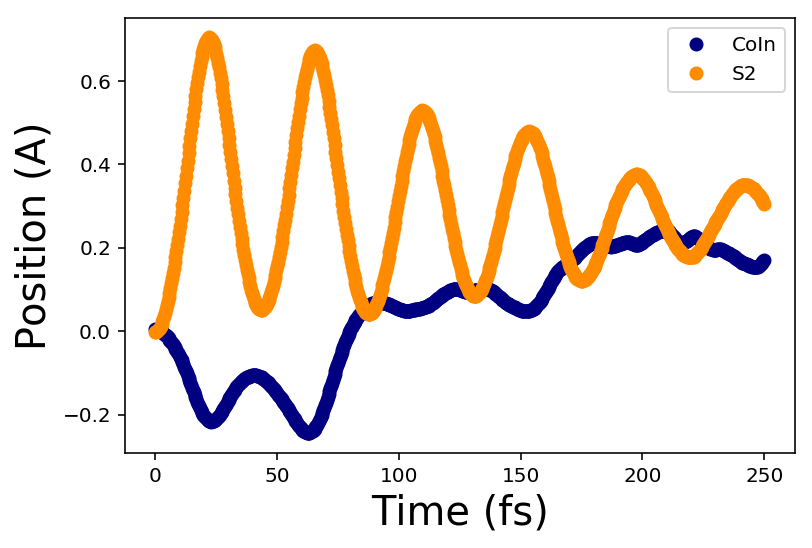

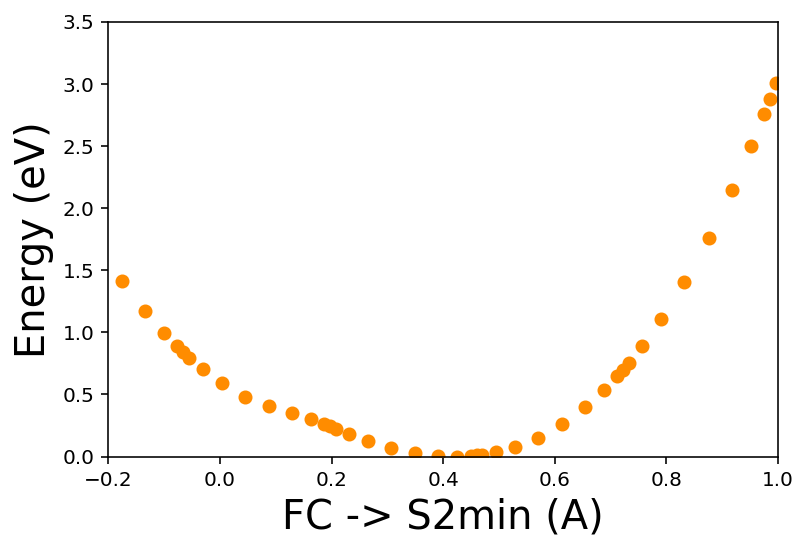

In [67]:
###_____________ Plot Projections ___________###

fig=figure()
plot(ts*autofs,(Exp_PosX_A/Exp_Pop_A)/angtobohr,'r--',marker="o",markersize=6,markevery=1,color=col[0],lw=0,label="CoIn")
plot(ts*autofs,(Exp_PosY_A/Exp_Pop_A)/angtobohr,'r--',marker="o",markersize=6,markevery=1,color=col[1],lw=0,label="S2")
legend()
xlabel("Time (fs)",size=20)
ylabel("Position (A)",size=20)

if saveplot==1:
    savefig(path+"/"+filename+"Project"+".pdf",dpi=300);


#---- PES Energy slice
fig=figure()

Z = uracil.s[2][:,ind_CoIn]/evtoau
Z = Z - Z.min()
plot(gridY.x/angtobohr,Z,marker="o",markersize=6,markevery=1,color=col[1],lw=0)
xlabel("FC -> S2min (A)",size=20)
ylabel("Energy (eV)",size=20)
xlim(-0.2,1)
ylim(0,3.5)

if saveplot==1:
    savefig(path+"/"+"Slice"+".pdf",dpi=300)


(-1, 2)

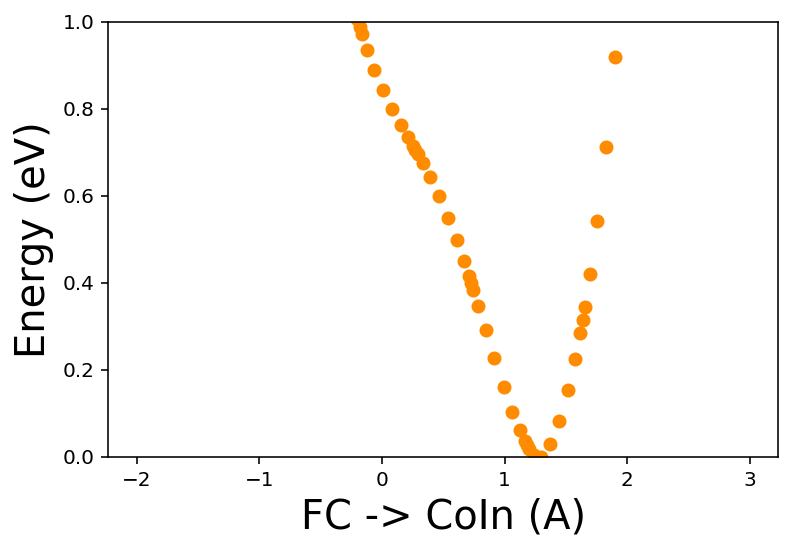

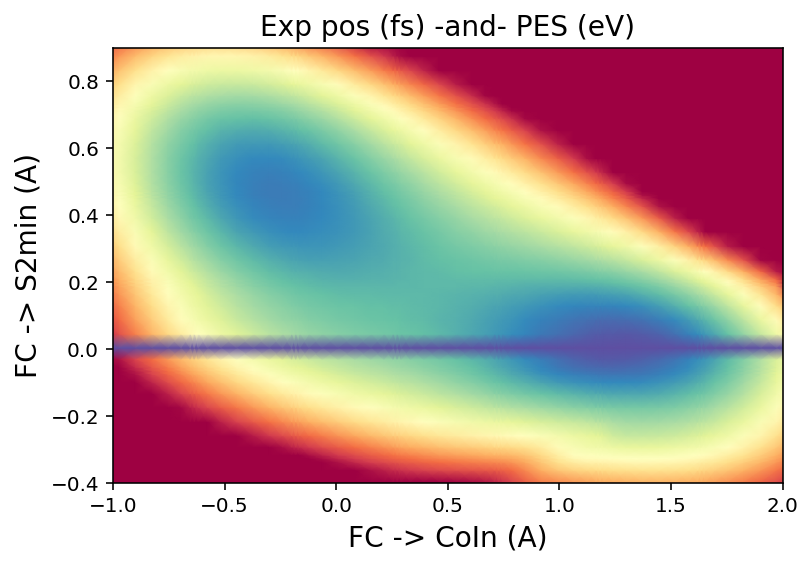

In [68]:
###_____________ Plot PES cut ___________###

value = 0*angtobohr
ind = abs(gridY.x - value).argmin() # find index

#---- PES Energy slice
fig=figure()

Z = uracil.s[2][ind,:]/evtoau
Z = Z - Z.min()
plot(gridX.x/angtobohr,Z,marker="o",markersize=6,markevery=1,color=col[1],lw=0)
xlabel("FC -> CoIn (A)",size=20)
ylabel("Energy (eV)",size=20)
#xlim(-0.2,1)
ylim(0,1)

#---- PES with line

fig = figure()
Z = uracil.s[2]/evtoau
Z = Z - min(Z.reshape(NRX*NRY))

Z[ind,:]=  0

pcolormesh(gridX.x/angtobohr,gridY.x/angtobohr,Z,shading='gouraud',vmin = 0, vmax = 3,cmap = 'Spectral_r')
textbx = "Exp pos (fs) -and- PES (eV)"
#fig.text(0.5, 0.8, textbx,  fontsize=14,verticalalignment='top', horizontalalignment='center')
title(textbx, fontsize=14)
xlabel("FC -> CoIn (A)",size=14)
ylabel("FC -> S2min (A)",size=14)

ylim(-0.4,0.9)
xlim(-1,2)


In [70]:
###_____________ Find Frank-Condon point ___________###

#value_CoIn = average(Exp_PosX_A/Exp_Pop_A)/angtobohr # Evaluate average position in CoIn coordinate
ind_FK = abs(uracil.s[0]).argmin() # find index

ind_FK = np.unravel_index(ind_FK, shape(uracil.s[0]))

uracil.s[2][ind_FK] - uracil.s[2].min()

0.03282022214141639